# Настройка

In [180]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [181]:
# делаем картинки побольше
plt.rcParams['figure.figsize'] = [10, 6]

In [182]:
# самописная функция, чтоб 100 раз не писать plt.imshow и конвертацию цветов
def show(img, title="Result", cmap=None):
    plt.figure()
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        # матплотлиб хочет RGB, а opencv грузит в BGR, надо свапнуть каналы
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off') # без осей
    plt.show()

# Задание 1

In [183]:
img1 = cv2.imread('img1.jpg')

In [184]:
# перегоняем в HSV, в задании просили через него делать
hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

In [185]:
# строим гистограмму по Насыщенности (S), т.к. объекты цветные, а фон серый
hist = cv2.calcHist([hsv], [1], None, [256], [0, 256])

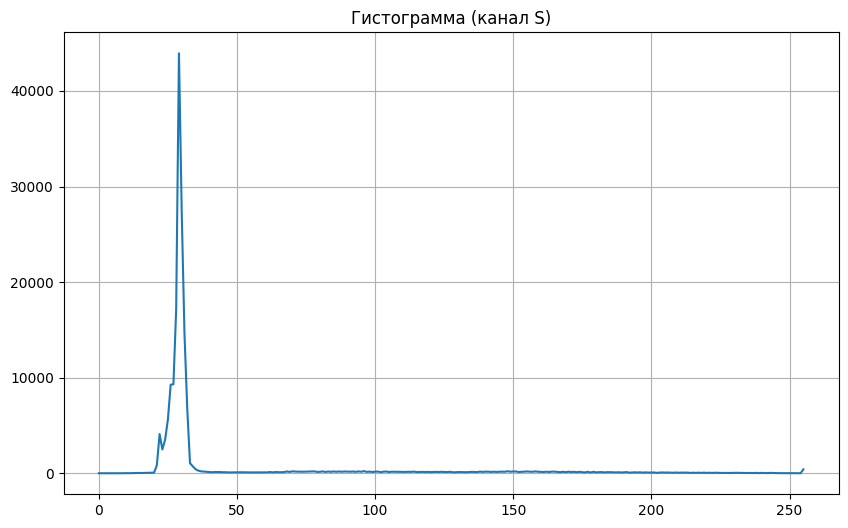

In [186]:
plt.plot(hist)
plt.title("Гистограмма (канал S)")
plt.grid()
plt.show()

In [187]:
# судя по графику, фон где-то возле нуля.
# берем порог 45 "на глаз", чтобы отсечь фон, но оставить камни
thresh_val = 45
_, binary_mask = cv2.threshold(s, thresh_val, 255, cv2.THRESH_BINARY)

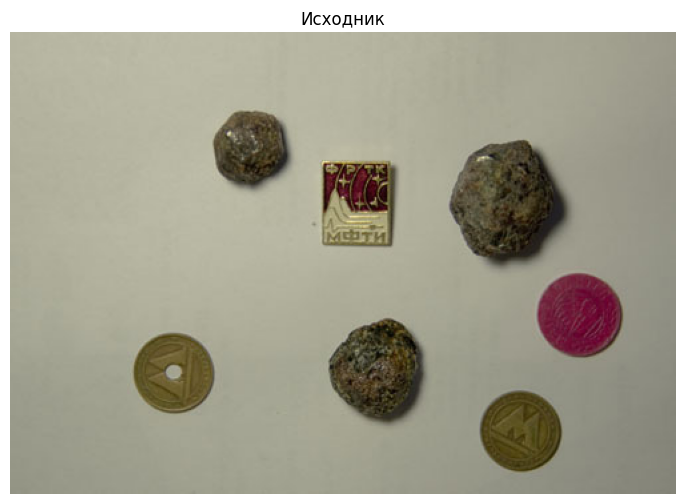

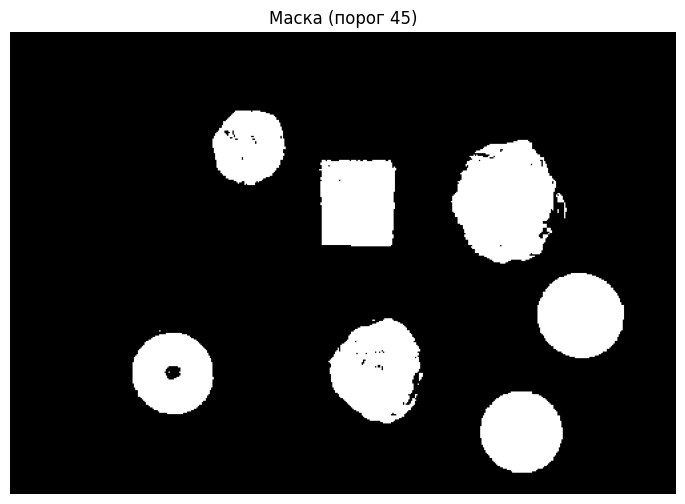

In [188]:
show(img1, "Исходник")
show(binary_mask, f"Маска (порог {thresh_val})", cmap='gray')

# Задание 2

In [189]:
img2 = cv2.imread('img2.jpg')
hsv2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
# Берем V (Value, Яркость)
channel = hsv2[:, :, 2]

In [190]:
# А: Сначала размываем, потом режем
# Гаусс уберет зерно
blurred = cv2.GaussianBlur(channel, (7, 7), 0)

In [191]:
# THRESH_BINARY_INV, потому что камни ТЕМНЫЕ (значения меньше порога),
# а нам нужно сделать их белыми на маске.
# THRESH_OTSU сам подберет идеальное число вместо 15 или 45.
_, mask_method_a = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

In [192]:
# Б: Сначала режем, потом чистим (тоже через V-канал и инверсию)
_, noisy_mask = cv2.threshold(channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

In [193]:
# Чистим шум морфологией
kernel = np.ones((5,5), np.uint8)
mask_method_b = cv2.morphologyEx(noisy_mask, cv2.MORPH_OPEN, kernel)
mask_method_b = cv2.morphologyEx(mask_method_b, cv2.MORPH_CLOSE, kernel)

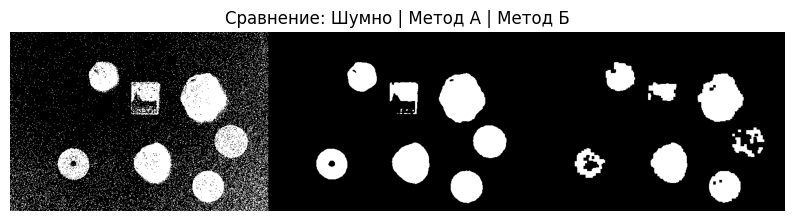

In [194]:
# Соединяем три маски в одну горизонтальную полосу
comparison = np.hstack([noisy_mask, mask_method_a, mask_method_b])

# Выводим через твою функцию одним куском
show(comparison, "Сравнение: Шумно | Метод А | Метод Б", cmap='gray')

# Задание 3

In [195]:
img = cv2.imread('img3.jpg')

In [196]:
# Выравниваем свет через LAB + CLAHE, иначе яйца в углах теряются в тенях
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
l = clahe.apply(l)
merged = cv2.merge((l, a, b))
final_img = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

In [197]:
# Переход в HSV для маски
hsv = cv2.cvtColor(final_img, cv2.COLOR_BGR2HSV)

In [198]:
# Пороги подобрал для коричневых яиц, игнорируя белые прутья
mask = cv2.inRange(hsv, (0, 40, 30), (40, 255, 255))

In [199]:
# Чистим шум (morph open) и чуть раздуваем (dilate), чтоб убрать дырки внутри
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
mask = cv2.dilate(mask, np.ones((3,3), np.uint8), iterations=2)

In [200]:
# Окончательно заливаем контуры
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filled_mask = np.zeros_like(mask)
for c in cnts:
    if cv2.contourArea(c) > 100: # мелочь скипаем
        cv2.drawContours(filled_mask, [c], -1, 255, -1)

In [201]:
# Считаем расстояние от пикселя до фона
dist = cv2.distanceTransform(filled_mask, cv2.DIST_L2, 5)

In [202]:
# Находим макс. радиус яйца на кадре, чтобы не хардкодить константы
r_max = np.max(dist)

In [203]:
# Сглаживаем карту (силу размытия берем от размера яйца)
k_blur = int(r_max / 2)
if k_blur % 2 == 0: k_blur += 1
dist_smooth = cv2.GaussianBlur(dist, (k_blur, k_blur), 0)

In [204]:
# Ищем локальные пики (центры)
k_loc = int(r_max / 3)
local_max = cv2.dilate(dist_smooth, np.ones((k_loc, k_loc), np.uint8))
peaks = (dist_smooth == local_max) & (dist_smooth > 0.15 * r_max)

In [205]:
# Собираем координаты пиков
ys, xs = np.where(peaks)
candidates = []
for i in range(len(ys)):
    candidates.append((xs[i], ys[i], dist_smooth[ys[i], xs[i]]))

In [206]:
# Сортируем: сначала самые явные и жирные центры
candidates.sort(key=lambda x: x[2], reverse=True)

In [207]:
# Фильтруем дубликаты по расстоянию
markers_pts = []
min_dist = r_max * 1.2 # Эмпирически: 1.2 радиуса отлично разделяет соседей
for c in candidates:
    cx, cy, _ = c
    is_new = True
    for m in markers_pts:
        # Обычная евклидова дистанция
        if math.hypot(cx - m[0], cy - m[1]) < min_dist:
            is_new = False
            break
    if is_new:
        markers_pts.append((cx, cy))
print(f"Найдено яиц: {len(markers_pts)}")

Найдено яиц: 25


In [208]:
# Создаем маркеры для алгоритма
markers = np.zeros(filled_mask.shape, dtype=np.int32)
for i, (cx, cy) in enumerate(markers_pts):
    cv2.circle(markers, (cx, cy), 5, i + 1, -1)

In [209]:
# Фон тоже надо пометить (всё, что далеко от яиц)
bg = cv2.dilate(filled_mask, np.ones((3,3), np.uint8), iterations=3)
markers[bg == 0] = len(markers_pts) + 100

In [210]:
# Запускаем водораздел
res_markers = cv2.watershed(img, markers)

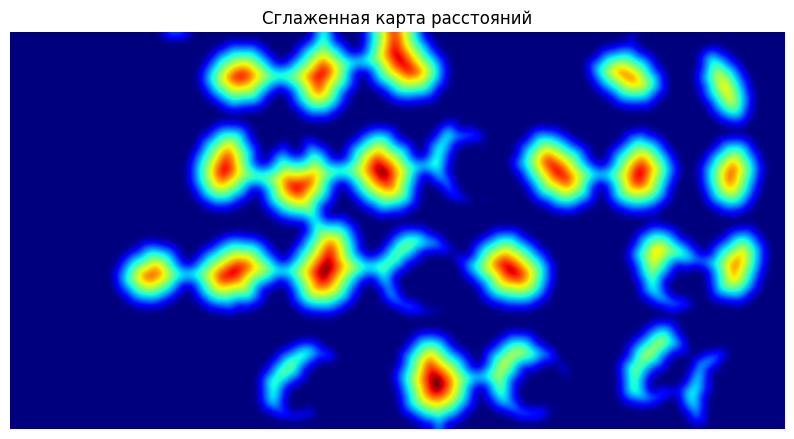

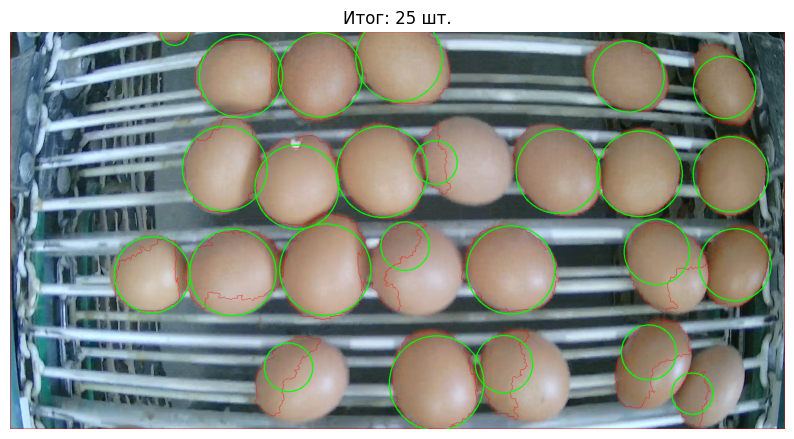

In [211]:
res = img.copy()
res[res_markers == -1] = [0, 0, 255] # Границы рисуем красным
for (cx, cy) in markers_pts:
    # Радиус берем из карты расстояний + небольшой запас
    r = int(dist[cy, cx]) + 10
    cv2.circle(res, (cx, cy), r, (0, 255, 0), 2)
# Выводим
show(dist_smooth, "Сглаженная карта расстояний", cmap='jet')
show(res, f"Итог: {len(markers_pts)} шт.")